# 2024 Qiskit Fall Fest at Korea University

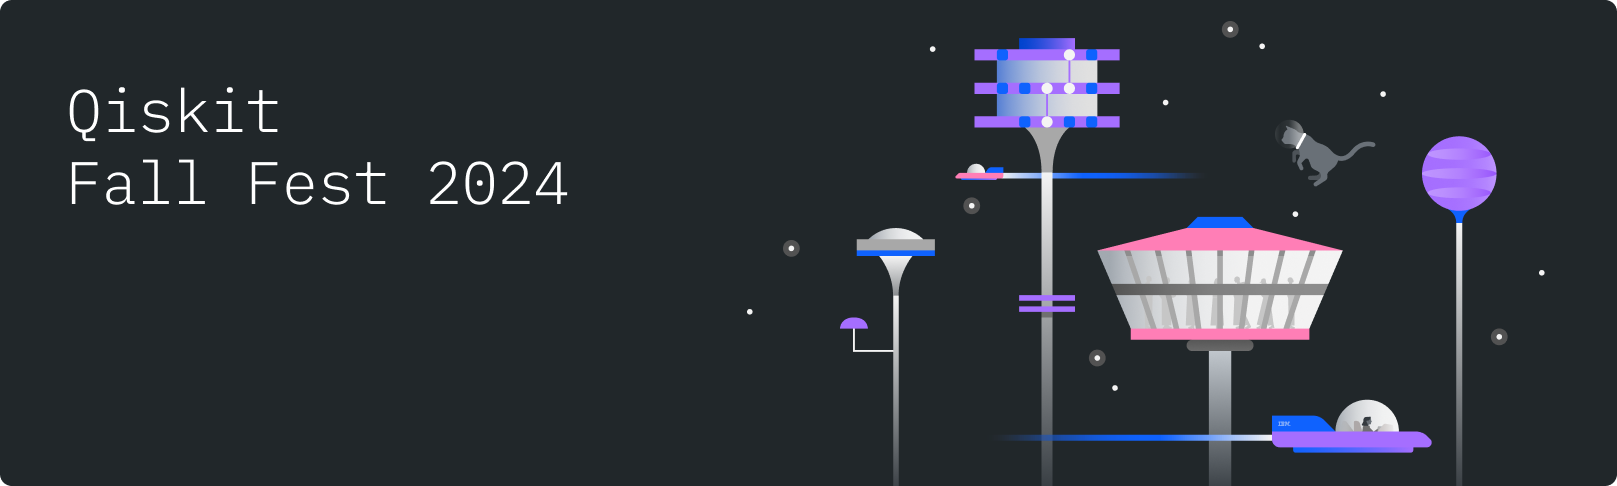

# Challenge 4: Classical Feedforward and Control Flow

## Part 0: Set up and Import the required packages

In [1]:
# If you use Colab, uncomment below line and run this cell
# %pip install git+https://github.com/goseumdochy/qiskit-fall-fest-2024ku-challenge-grader.git

In [1]:
### Import the required packages

import numpy as np

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram, plot_bloch_multivector

### IBM Quantum API token 을 저장하기

1. [IBM Quantum Platform](https://quantum.ibm.com/) 에 접속하여 로그인 하기
2. 우측 상단의 API token 복사하기 버튼 클릭하기(위의 그림 참고)
3. 아래의 코드셀에서 `Your_token_here` 부분을 여러분의 API token으로 대체하기
4. 여러분의 API token은 쌍따옴표 안에 있어야합니다!!

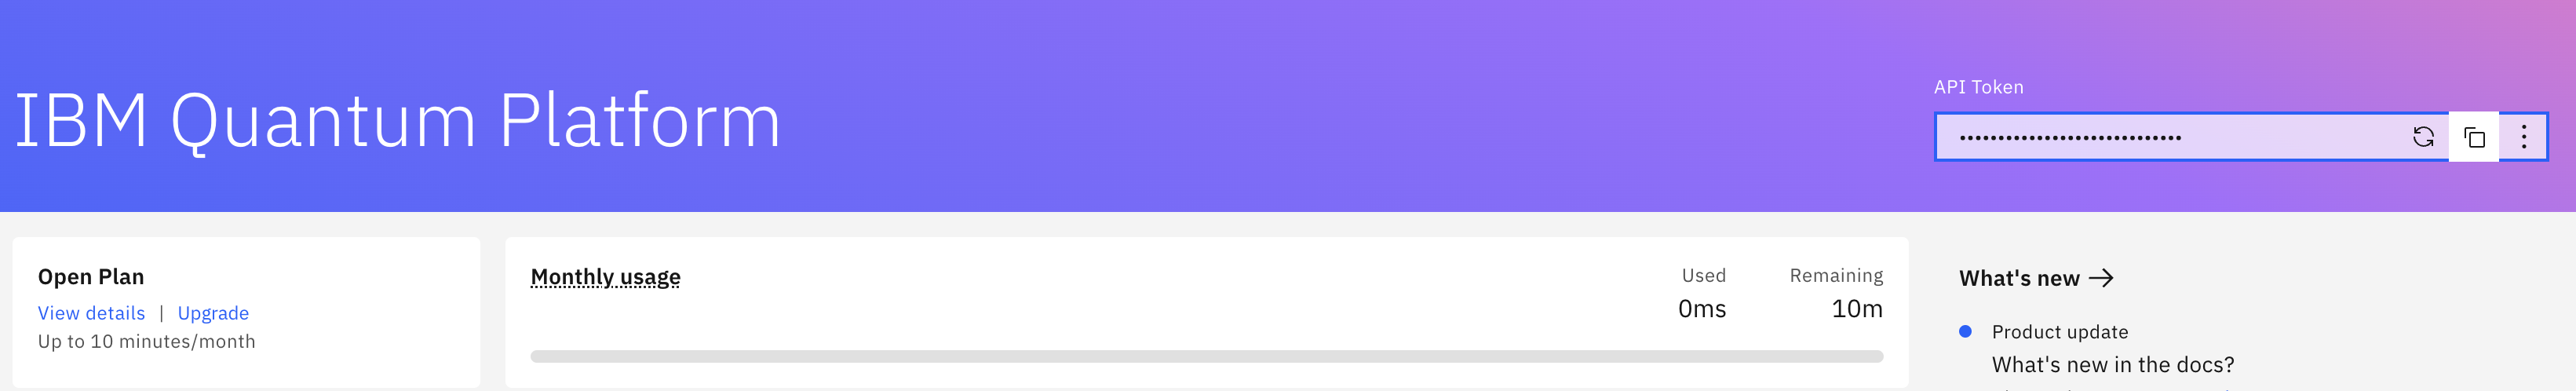

In [4]:
## Save an IBM Quantum account and set it as your default account.
QiskitRuntimeService.save_account(

    channel="ibm_quantum",

    token="Your_token_here",

    set_as_default=True,

    # Use `overwrite=True` if you're updating your token.
    overwrite=True,
)

# Load saved credentials
service = QiskitRuntimeService()

### 정보 기입하기

기입해준 정보를 바탕으로 서버에 참가자 식별이 되오니, 특히 학번(student_id)은 정확하게 기입해주시길 바랍니다!

In [2]:
event = "2024 Qiskit Fall Fest at Korea University"

## Write your code below here. Delete the current information and replace it with your own ##
## Make sure to write your information between the quotation marks!

username = "ndtqiv"

major = "Electrical Engineering"

student_id = "202017xxxx"

## Now press the "Run" button in the toolbar above, or press Shift + Enter while you're active in this cell

## Part 1: Intro To Classical feedforward and control flow

Qiskit 교육자료인 [Qiskit textbook](https://learn.qiskit.org/course/ch-algorithms/quantum-circuits)에는 다음과 같은 말이 있습니다.
>_"A quantum circuit is a computational routine consisting of coherent quantum operations on qubits ... It is an ordered sequence of quantum gates, measurements and resets, all of which may be conditioned on and use data from the real-time classical computation."_

위 문구를 한국말로 직해하면 다음과 같습니다.
>_양자 회로는 qubit에 대한 일관성 있는 양자 연산으로 구성된 계산 루틴입니다 ... 양자 gate, 측정 및 리셋의 순서대로 나열되는 것이며, 이 모든 것은 실시간 고전 컴퓨팅 계산의 데이터에 따라 조건화되어 사용될 수 있습니다._

인용구의 마지막 문장이 잘 이해가 되지 않으실 수 있습니다. 하지만 그 문장이 classicial feedforward and control forward(dynamic circuit 이라고도 불림)와 직접적으로 연관된 내용입니다. 별다른 수식어 없이 양자 회로라고 말하면 보통 _static_ 양자 회로를 의미합니다. 이전 챌린지에서 봤던 것들은 전부 static 양자 회로입니다. 그러다면 dynamic circuits은 무엇일까요?

지금까지 여러분이 챌린지에서 봐왔던 양자 회로들은 전부 $|0\rangle$ 상태에서 시작하여, 양자 gate들을 가하고, 마지막에 측정을 하는 방식이었습니다. 반면에 **Dynamic circuits**은 양자 회로 중간에 측정을 하여, 그 측정 결과를 바탕으로 후반부 양자 gate 를 어떻게 가할지 결정하는 양자 회로입니다. 이러한 측정 결과는 당연하게도 중첩 같은 성질이 없는 고전적인 값이며, 이러한 고전적인 측정 결과에 따라 이후의 양자 연산을 조건화하는 것을 _classical feedforward_ 라고 합니다.

왜 classical feedforward가 필요할까요? 이러한 feedforward가 필요한 대표적인 예시는 conditional reset이라고 불리는 과정이며 Qiskit에서는 [`reset`](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.reset.html) 연산이 이에 해당 합니다. reset은 non-unitary 연산자로서 이전의 양자 상태가 무슨 상태인지 상관없이 reset 연산을 거치면 그 qubit의 양자 상태는 $|0\rangle$ 상태가 됩니다. 이 reset 연산은 다음과 같은 과정을 통해 이루어집니다. 해당 qubit을 측정한 후에, 측정 결과가 $|0\rangle$이면 아무런 행동을 취하지 않고, 측정 결과가 $|1\rangle$ 이라면 X gate를 가해서 $|0\rangle$ 상태로 만듭니다. 즉, 해당 qubit를 측정하여 $|0\rangle$ 혹은 $|1\rangle$ 상태로 붕괴(collapse)시키고, 만약 $|1\rangle$라면 X gate를 가해 $|0\rangle$로 만들어 주는 것입니다.

이러한 conditional reset 연산을 보시면 qubit 측정 후에 측정 결과를 기반으로 X gate를 가할지 말지 결정하기에 해당 연산이 들어간 회로는 dynamic circuit 이라고 할 수 있습니다.

<center>
<img src="../img/sketch-1.png" width="50%">
</center>

동적 회로는 'if'문 및 'while' 루프와 같은 제어 흐름을 포함하는 양자 회로로 볼수 도 있습니다.

### Hello Dynamic Circuit World

IBM Quantum의 실제 양자컴퓨터에서는 이미 한동안 회로 중간 측정 및 리셋을 지원하였지만, 그 측정 결과를 이용하여 이후의 양자 gate를 어떻게 가할지 결정하는 classical feedforward 기능은 2022년에야 도입되었습니다. Classical feedforward 기능을 지원하기 위해서는 제어 시스템 및 관련 소프트웨어를 대폭 재설계해야 했기 때문입니다.

Classical feedforward 기능을 구현하는 가장 기본적인 방법은 `QuantumCircuit` 클래스의 [`if_test()`](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.QuantumCircuit#if_test) 매서드를 사용하는 것입니다.

먼저 앞에서 dynamic circuit의 예시로 보여드렸던 conditional reset을 `if_test()`매서드를 이용하여 구현하는 것을 예제로 보여드리겠습니다. 다음의 과정을 통해 양자 회로를 만들어 나갈 것입니다.

1. 1개의 qubit과 2개의 classical bits를 가진 양자 회로를 만듭니다. (1개의 qubit과 2개의 classical bits의 이름은 `q0`, `b0`, 그리고 `b1`으로 합니다)
2. `q0`에 hadamard gate를 가합니다.
3. `q0`를 측정하고 그 결과를 `b0`에 저장합니다.
4. `if_test` 명령어를 이용하여 `b0` == 1 인지 확인합니다.
5. 만약 `b0` == 1 이라면 `q0`에 X gate를 가하여 $|0\rangle$로 만들어 줍니다.
6. 그 후 `q0`를 측정하고 그 결과를 `b1`에 저장하고 그 값을 체크하여 항상 0이 나오는지 확인합니다.

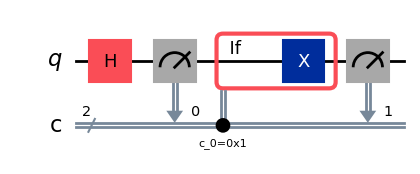

In [3]:
qr = QuantumRegister(1, name='q')
cr = ClassicalRegister(2, name='c')
qc = QuantumCircuit(qr, cr)

# unpack the qubit and classical bits from the registers
(q0,) = qr
b0, b1 = cr

# apply Hadamard
qc.h(q0)
# measure
qc.measure(q0, b0)

# begin if test block. the contents of the block are executed if b0 == 1
with qc.if_test((b0, 1)):
    # if the condition is satisfied (b0 == 1), then flip the bit back to 0
    qc.x(q0)
# finally, measure q0 again
qc.measure(q0, b1)

qc.draw(output="mpl", idle_wires=False)

양자 회로를 만들었으니 이 회로를 여러번 실행시키겠습니다. 첫번째 측정은 0 또는 1이 각각 절반의 확률로 나오겠지만 두번째 측정은 항상 0이 나오는 것을 확인하시길 바랍니다.

In [4]:
# initialize the backend and sampler
backend = AerSimulator()
sampler = Sampler(backend)

# Make a pub and execute our circuit
pub = (qc)
job_sampler = sampler.run([pub], shots=10000)

result_sampler = job_sampler.result()
counts_sampler = result_sampler[0].data.c.get_counts()

print(f"Counts: {counts_sampler}")

Counts: {'01': 4946, '00': 5054}


예상한 바와 같이 첫 번째 측정 결과는 0또는 1 모두 나올 수 있지만, 두 번째 측정 결과는 0만 나옵니다. Qiskit은 little-endian ordering을 사용한다는 것을 잊지 말기 바랍니다. 문자열 오른쪽이 첫 번째 bit(`b0`)이고, 문자열 왼쪽이 두 번째 bit(`b1`)입니다.

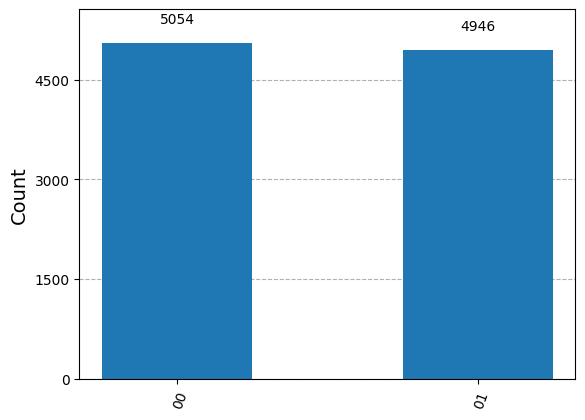

In [5]:
plot_histogram(counts_sampler)

위에서는 측정 값이 특정한 조건을 만족할 때, 특정 행동을 하는 회로를 만들었습니다. 그럼 특정 조건을 만족하지 않을 때 어떠한 연산을 가하기 위해서는 어떻게 해야할까요? 파이썬에서 if와 함께 자주 나오는 else문이 생각나시나요? 이와 같은 개념이 dynamic circuit에도 존재합니다. 아래와 같이 코딩하면 됩니다.

In [6]:
with qc.if_test(조건) as else_:
    # 조건 만족할 때 수행할 작업
    
with else_:
    # 조건 불만족 시 수행할 작업

IndentationError: expected an indented block after 'with' statement on line 1 (3587900472.py, line 4)

예시는 아래에 있습니다.

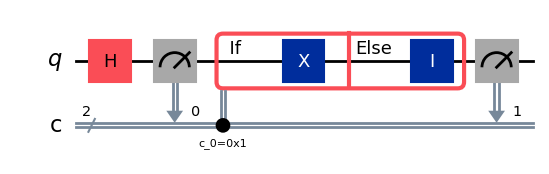

In [6]:
from qiskit import QuantumCircuit
from qiskit.circuit import QuantumRegister, ClassicalRegister

qr = QuantumRegister(1, name='q')
cr = ClassicalRegister(2, name='c')
qc = QuantumCircuit(qr, cr)

# unpack the qubit and classical bits from the registers
(q0,) = qr
b0, b1 = cr

# apply Hadamard
qc.h(q0)
# measure
qc.measure(q0, b0)

# begin if test block. the contents of the block are executed if b0 == 1
with qc.if_test((b0, 1)) as else_:
    # if the condition is satisfied (b0 == 1), then flip the bit back to 0
    qc.x(q0)


with else_:
    # if the condition is satisfied (b0 != 1), then apply identity operator to 0
    qc.id(q0)
# finally, measure q0 again
qc.measure(q0, b1)

qc.draw(output="mpl", idle_wires=False)

이제 여러분의 dynamic circuit을 만들어 봅시다!

<div class="alert alert-block alert-success">

### Exercise 1: Your first classical feedforward and control flow

앞의 예시보다는 조금 더 복잡한 것을 만들어야 합니다. 2개의 큐비트와 2개의 고전비트를 가진 양자 회로를 만들고 `q0`의 관측 결과에 따라 `q1`에 가하는 gate를 다르게 할 것 입니다. 여러분이 만드셔야 하는 회로는 만약 `q0` 관측 결과가 0이라면 $X$ 게이트를 `q1`에 가하고, `q0` 관측 결과가 1이라면 Hadamard 게이트를 `q1`에 가하는 회로입니다. 아래에 자세히 설명드리겠습니다.

**해야할 일:**  아래의 코드 셀을 보시면 `q0` 관측 결과에 무작위성을 부여하기 위해 `q0`에 Hadmard 게이트를 처음에 가해두었습니다. 그 후, `q0`의 관측 결과를 `b0`에 저장할 것입니다. 그 후 윗 문단에서 말한 classical feedforward 조건에 기반하여 `q1`에 gate를 가하고 `q1`을 측정한 결과를 `b1`에 저장할 것입니다.

만약, `if_test()` 문을 작성하는 것에 어려움이 있으시다면 [링크](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.QuantumCircuit#if_test)를 클릭하여 `if_test()` 다큐멘테이션을 참고하시길 바랍니다.

**단, `if_test()` 문은 한 번만 사용하셔야 합니다.**
    
</div>

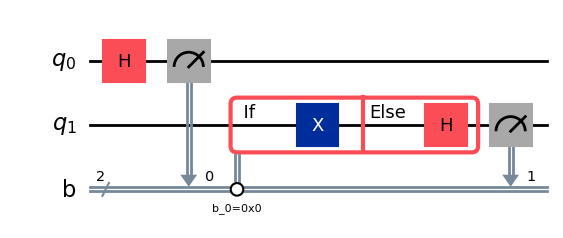

In [7]:
qr = QuantumRegister(2, name = "q")
cr = ClassicalRegister(2, name = "b")
qc = QuantumCircuit(qr, cr)

q0, q1 = qr
b0, b1 = cr

qc.h(q0)
qc.measure(q0, b0)


### Write your code below this line ### 
with qc.if_test((b0, 0)) as else_:
    # if the condition is satisfied (b0 == 1), then flip the bit back to 0
    qc.x(q1)

with else_:
    # if the condition is satisfied (b0 != 1), then apply identity operator to 0
    qc.h(q1)
### Do not change the code below this line ###


qc.measure(q1, b1)
answer1 = qc
qc.draw(output="mpl", idle_wires=False)

아래에서 여러분이 만든 회로가 잘 작동하는지 확인할 수 있습니다. 어떠한 결과가 나와야 하는지 미리 생각해보고 아래의 코드 셀 실행시켜보는 것도 좋을 것 같습니다.

In [8]:
# initialize the backend and sampler
backend = AerSimulator()
sampler = Sampler(backend)

# Make a pub and execute our circuit
pub = (qc)
job_sampler = sampler.run([pub], shots=10000)

result_sampler = job_sampler.result()
counts_sampler = result_sampler[0].data.b.get_counts()

print(f"Counts: {counts_sampler}")

Counts: {'10': 5031, '11': 2544, '01': 2425}


In [9]:
### Grader Cell - Submit your answer by running the following code
### You do not need to add any code into this cell

from qff_2024ku_grader.challenges.qff_ku2024 import grade_challenge4a

grade_challenge4a(answer1, username)

Grading your answer. Please wait...

Congratulations 🎉! Your answer is correct.


<div class="alert alert-block alert-success">

### Exercise 2: Result Analysis

이상적인 경우 위의 회로에서 각각의 결과가 나올 확률은 어떻게 될까요?

**해야할 일:** 아래의 코드 셀을 보시면 딕셔너리 자료형의 `answer2`를 선언해 두었습니다. 각각의 키에 해당하는 밸류값으로 해당 키 값이 관측될 확률을 넣어주시면 됩니다. **Qiskit은 little-endian 표기법을 따른다는 것을 잊지 마세요!!**

**참고:** 확률은 소수 표현으로 적으셔도 되고, 나눗셈 표현으로 적으셔도 됩니다. 소수로 표현할 때 무한 소수가 나오는 경우에는 나눗셈 형태로 적으시면 됩니다. 예를 들어, $\frac{1}{6}$ 확률을 적고 싶은 경우에는 0.166666 이 아닌 1/6로 적으시면 채점이 올바르게 될 것입니다.

</div>

In [10]:
answer2 = {}

answer2['00'] = 0   ## add your code here
answer2['01'] = 1/4 ## add your code here
answer2['10'] = 1/2 ## add your code here
answer2['11'] = 1/4 ## add your code here

In [11]:
### Grader Cell - Submit your answer by running the following code
### You do not need to add any code into this cell

from qff_2024ku_grader.challenges.qff_ku2024 import grade_challenge4b

grade_challenge4b(answer2, username)

Grading your answer. Please wait...

Congratulations 🎉! Your answer is correct.


## Part 2: Anather method for classical feedforward and control flow

Classical feedforward와 control flow는 `if_test()`문 말고도 다른 메서드를 이용해서도 할 수 있습니다. 여기서는 `switch`, `for_loop`, `while_loop` 메서드들에 대해서 설명드리겠습니다. 

- If statement - [`QuantumCircuit.if_test`](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.QuantumCircuit#if_test)
- Switch statement - [`QuantumCircuit.switch`](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.QuantumCircuit#switch)
- For loop - [`QuantumCircuit.for_loop`](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.QuantumCircuit#for_loop)
- While loop - [`QuantumCircuit.while_loop`](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.QuantumCircuit#while_loop)

### Switch statement

`switch` 문은 고전적인 비트의 값에 따라 동작을 선택하는 데 사용됩니다. 이는 `if_test` 문과 비슷하지만, 분기 로직에 대해 더 많은 경우를 지정할 때 편리하게 사용할 수 있습니다. Swith문이 있는 프로그래밍 언어(예를 들어, C언어, 3.10버전 이상의 파이썬)를 다뤄 본 분이시라면 익숙한 형태일 것입니다. 아래 예시에서는, 1-큐비트 양자 회로의 큐비트에 hadamard 게이트를 적용하고 측정합니다. 측정 결과가 0이면 큐비트에 X 게이트를 적용하고, 결과가 1이면 Z 게이트를 적용합니다. 결과적인 측정 값은 100% 확률로 1이어야 합니다.

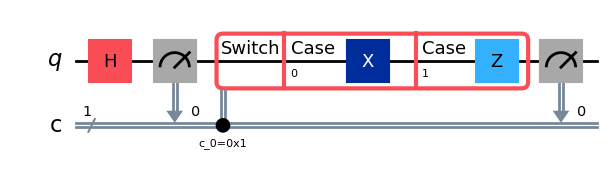

In [12]:
qubits = QuantumRegister(1, name='q')
clbits = ClassicalRegister(1, name='c')
circuit = QuantumCircuit(qubits, clbits)
(q0,) = qubits
(c0,) = clbits
 
circuit.h(q0)
circuit.measure(q0, c0)
with circuit.switch(c0) as case:
    with case(0):
        circuit.x(q0)
    with case(1):
        circuit.z(q0)
circuit.measure(q0, c0)
 
circuit.draw("mpl")
 
# example output counts: {'1': 1024}

In [13]:
# initialize the backend and sampler
backend = AerSimulator()
sampler = Sampler(backend)

# Make a pub and execute our circuit
pub = (circuit)
job_sampler = sampler.run([pub], shots=10000)

result_sampler = job_sampler.result()
counts_sampler = result_sampler[0].data.c.get_counts()

print(f"Counts: {counts_sampler}")

Counts: {'1': 10000}


위 예제에서는 1개의 고전 비트를 사용하였기 때문에 가능한 경우는 두 가지뿐이었고, 이는 if-else 문을 사용하여 동일한 결과를 얻을 수 있습니다. `switch` 문은 여러 비트로 구성된 고전 레지스터의 값을 기준으로 다양한 분기를 할 때 주로 유용하며, 다음 예제에서 이를 보여줍니다. 아래 예제에서는 어떠한 경우에도 해당되지 않을 때 실행되는 기본(default) 케이스를 구성하는 방법도 함께 볼 수 있습니다. `switch` 문은 단 하나의 블록만 실행되며, 하위 블록으로는 이어지지 않는다는 점에 유의하세요.

아래 예제에서는 두 큐비트에 각각 hadamard 게이트를 적용한 후 측정합니다. 
- 측정 결과가 00 또는 11이면 세 번째 큐비트에 Z 게이트를 적용합니다.
- 측정 결과가 01이면 세 번째 큐비트에 Y 게이트를 적용합니다.
- 이전의 어떤 경우도 해당하되지 않으면 X 게이트를 적용합니다
- 마지막으로 세 번째 큐비트를 측정합니다.

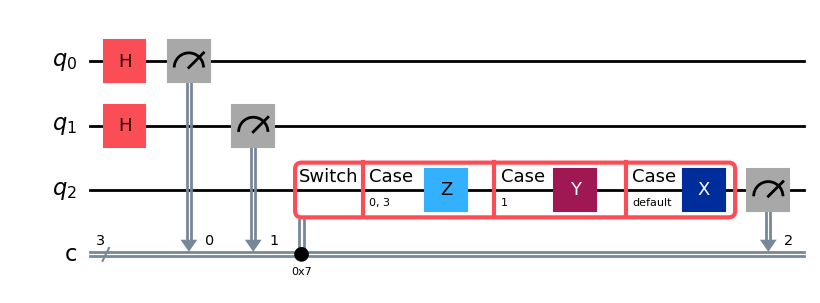

In [14]:
qubits = QuantumRegister(3, name='q')
clbits = ClassicalRegister(3, name='c')
circuit = QuantumCircuit(qubits, clbits)
(q0, q1, q2) = qubits
(c0, c1, c2) = clbits
 
circuit.h([q0, q1])
circuit.measure(q0, c0)
circuit.measure(q1, c1)
with circuit.switch(clbits) as case:
    with case(0b000, 0b011):
        circuit.z(q2)
    with case(0b001):
        circuit.y(q2)
    with case(case.DEFAULT):
        circuit.x(q2)
circuit.measure(q2, c2)
 
circuit.draw("mpl")
 
# example output counts: {'101': 267, '110': 249, '011': 265, '000': 243}

### For loop

For loop는 클래식 값의 시퀀스를 반복하면서 각 반복마다 몇몇 연산을 수행하는데 사용됩니다.

아래 예제에서는 for loop를 사용하여 큐비트 하나에 5번의 X 게이트를 적용한 후 이를 측정합니다. X 게이트를 홀수 번 적용했기 때문에, 최종적인 효과는 큐비트를 $|0\rangle$에서 $|1\rangle$로 뒤집는 것입니다.

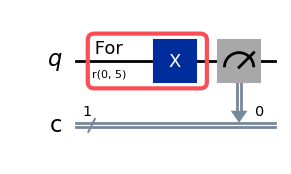

In [15]:
qubits = QuantumRegister(1, name='q')
clbits = ClassicalRegister(1, name='c')
circuit = QuantumCircuit(qubits, clbits)
(q0,) = qubits
(c0,) = clbits
 
with circuit.for_loop(range(5)) as _:
    circuit.x(q0)
circuit.measure(q0, c0)
 
circuit.draw("mpl")
 
# example output counts: {'1': 1024}

### While loop

While loop는 특정 조건이 만족되는 동안 명령을 반복하는 데 사용됩니다.

아래 예제에서는 두 큐비트에 hadamard 게이트를 적용하고 이를 측정합니다. 그런 다음, 측정 결과가 11일 동안 이 절차를 반복하는 while 루프를 만듭니다. 그 결과, 최종 측정은 절대 11이 되지 않으며, 나머지 가능한 결과는 대략 동일한 빈도로 나타나야 합니다.

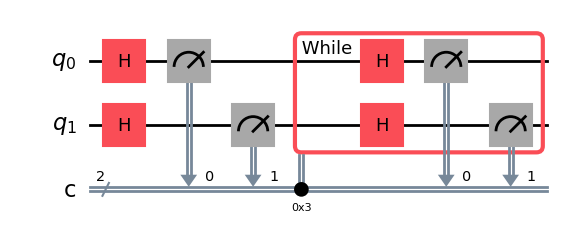

In [16]:
qubits = QuantumRegister(2, name='q')
clbits = ClassicalRegister(2, name='c')
circuit = QuantumCircuit(qubits, clbits)
 
q0, q1 = qubits
c0, c1 = clbits
 
circuit.h([q0, q1])
circuit.measure(q0, c0)
circuit.measure(q1, c1)
with circuit.while_loop((clbits, 0b11)):
    circuit.h([q0, q1])
    circuit.measure(q0, c0)
    circuit.measure(q1, c1)
 
circuit.draw("mpl")
 
# example output counts: {'01': 334, '10': 368, '00': 322}

In [17]:
# initialize the backend and sampler
backend = AerSimulator()
sampler = Sampler(backend)

# Make a pub and execute our circuit
pub = (circuit)
job_sampler = sampler.run([pub], shots=10000)

result_sampler = job_sampler.result()
counts_sampler = result_sampler[0].data.c.get_counts()

print(f"Counts: {counts_sampler}")

Counts: {'01': 3351, '00': 3346, '10': 3303}


### Break loop, Continue loop

`Break`와 `Continue`는 반복문에서 control flow하는데 사용되는 두 가지 중요한 명령어입니다. 이 두 명령어는 반복문 내에서 특정 조건이 발생했을 때 반복을 중단하거나 건너뛰도록 할 수 있습니다.

`break_loop` 는 반복문을 완전히 **종료**시키는 명령어입니다. For loop, while loop 등의 반복문 안에서 `break`가 실행되면, 해당 반복문을 즉시 빠져나오고, 반복문 이후의 코드가 실행됩니다. 주로 특정 조건이 만족되었을 때 반복을 멈추기 위해 사용됩니다. Qiskit에서는 특정 조건을 `c_if` 메서드를 이용하여 명시합니다.

`continue_loop` 는 현재 반복을 **건너 뛰고**, 다음 반복으로 넘어가게 합니다. 즉, 반복문은 종료되지 않지만, continue 이후의 코드가 실행되지 않고 다음 반복이 시작됩니다. 특정 조건에서 반복문의 일부를 무시하고 계속해서 다음 반복을 진행할 때 사용됩니다.

예시를 보겠습니다. 다음은 break 문이 없다면 X 게이트가 10번 가해져서 결국에는 0이 측정되어야 하지만, break 문에 의해 측정 결과가 1이 될 때(X 게이트를 한 번 가했을 때) 반복문을 탈출하여 1이 측정되는 것을 확인할 수 있습니다.

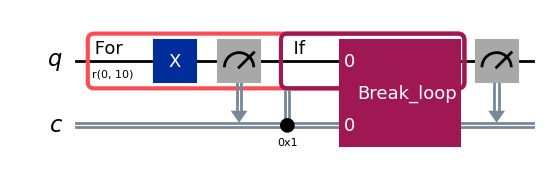

In [18]:
# Prepare quantum and classical bits
qubits = QuantumRegister(1, name='q')
clbits = ClassicalRegister(1, name='c')
circuit = QuantumCircuit(qubits, clbits)
(q0,) = qubits
(c0,) = clbits

# A loop to flip the qubit 10 times
with circuit.for_loop(range(10)) as i:
    circuit.x(q0)               # Apply X gate to flip the qubit state
    circuit.measure(q0, c0)     # Measure the state of q0
    with circuit.if_test((clbits, 1)):
        circuit.break_loop()  # Break the loop if the measurement result is 1

# Final measurement
circuit.measure(q0, c0)

# Visualize the circuit
circuit.draw('mpl')


In [19]:
# initialize the backend and sampler
backend = AerSimulator()
sampler = Sampler(backend)

# Make a pub and execute our circuit
pub = (circuit)
job_sampler = sampler.run([pub], shots=10000)

result_sampler = job_sampler.result()
counts_sampler = result_sampler[0].data.c.get_counts()

print(f"Counts: {counts_sampler}")

Counts: {'1': 10000}


<div class="alert alert-block alert-success">

### Exercise 3: Make the same dynamical circuit

**해야할 일:**  아래에 주어진 양자회로와 같은 양자회로를 만들어주세요.
    
</div>

<div class="alert alert-block alert-warning">

아래 그림에서 IF 문 파란색 박스 오른쪽 변과 For 문 자주색 박스 오른쪽 변이 겹쳐져 있습니다. 즉 For 문 안에 If 문이 있습니다. 그림에서는 잘 안 보여 이렇게 말씀드립니다.

</div>

![Quantum circuit](../img/quantum_circuit.png)

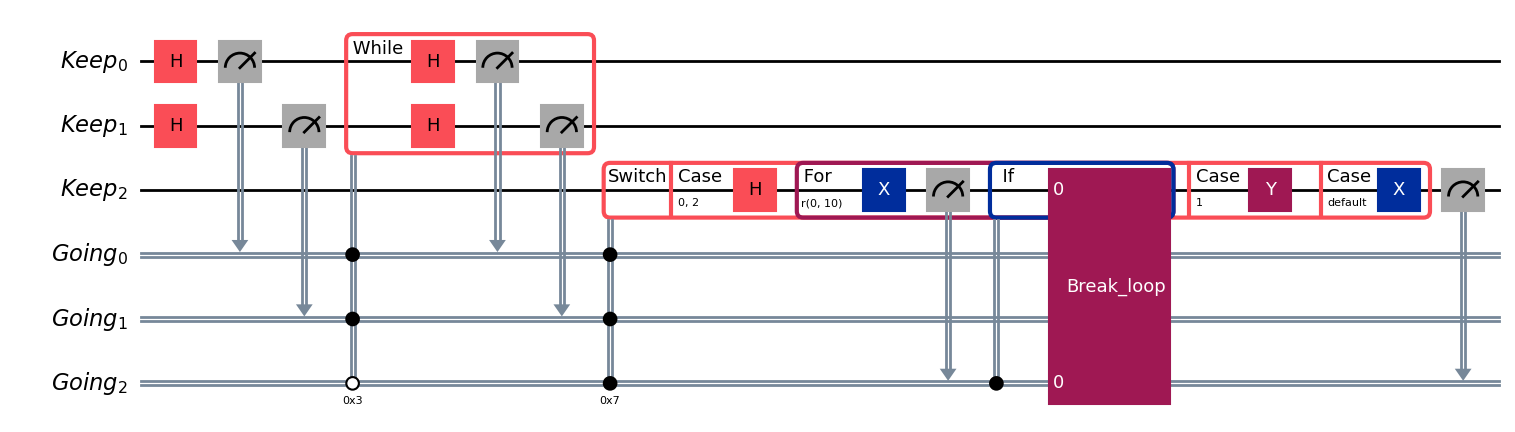

In [20]:
qubits = QuantumRegister(3, name='Keep')
clbits = ClassicalRegister(3, name='Going')
circuit = QuantumCircuit(qubits, clbits)
 
q0, q1, q2 = qubits
c0, c1, c2 = clbits

### Write your code below this line ### 

circuit.h([q0, q1])
circuit.measure(q0, c0)
circuit.measure(q1, c1)
with circuit.while_loop((clbits, 0b11)):
    circuit.h([q0, q1])
    circuit.measure(q0, c0)
    circuit.measure(q1, c1)

with circuit.switch(clbits) as case:
    with case(0b000, 0b010):
        circuit.h(q2)
        with circuit.for_loop(range(10)) as i:
            circuit.x(q2)
            circuit.measure(q2, c2)
            with circuit.if_test((c2, 1)):
                circuit.break_loop()
    with case(0b001):
        circuit.y(q2)
    with case(case.DEFAULT):
        circuit.x(q2)
 
circuit.measure(q2, c2)
 
### Do not change the code below this line ###

answer3 = circuit
fig = circuit.draw("mpl")
circuit.draw('mpl')

# fig.savefig('../img/quantum_circuit.png')

In [21]:
# initialize the backend and sampler
backend = AerSimulator()
sampler = Sampler(backend)

# Make a pub and execute our circuit
pub = (circuit)
job_sampler = sampler.run([pub], shots=10000)

result_sampler = job_sampler.result()
counts_sampler = result_sampler[0].data.Going.get_counts()

print(f"Counts: {counts_sampler}")

Counts: {'100': 3325, '110': 3275, '101': 3400}


In [22]:
### Grader Cell - Submit your answer by running the following code
### You do not need to add any code into this cell

from qff_2024ku_grader.challenges.qff_ku2024 import grade_challenge4c

grade_challenge4c(answer3, username)

Grading your answer. Please wait...

Congratulations 🎉! Your answer is correct.


<div class="alert alert-block alert-success">

### Exercise 4: Result Analysis

이상적인 경우 위의 회로에서 각각의 결과가 나올 확률은 어떻게 될까요?

**해야할 일**: 아래의 코드 셀을 보시면 딕셔너리 자료형의 `answer4`를 선언해 두었습니다. 각각의 키에 해당하는 밸류값으로 해당 키 값이 관측될 확률을 넣어주시면 됩니다. **Qiskit은 little-endian 표기법을 따른다는 것을 잊지 마세요!!**

**참고:** 확률은 소수 표현으로 적으셔도 되고, 나눗셈 표현으로 적으셔도 됩니다. 소수로 표현할 때 무한 소수가 나오는 경우에는 나눗셈 형태로 적으시면 됩니다. 예를 들어, $\frac{1}{6}$ 확률을 적고 싶은 경우에는 0.166666 이 아닌 1/6로 적으시면 채점이 올바르게 될 것입니다.

</div>

In [23]:
answer4 = {}

answer4['000'] = 0   ## add your code here
answer4['001'] = 0   ## add your code here
answer4['010'] = 0   ## add your code here
answer4['011'] = 0   ## add your code here
answer4['100'] = 1/3 ## add your code here
answer4['101'] = 1/3 ## add your code here
answer4['110'] = 1/3 ## add your code here
answer4['111'] = 0   ## add your code here

In [24]:
### Grader Cell - Submit your answer by running the following code
### You do not need to add any code into this cell

from qff_2024ku_grader.challenges.qff_ku2024 import grade_challenge4d

grade_challenge4d(answer4, username)

Grading your answer. Please wait...

Congratulations 🎉! Your answer is correct.


## Part 3: Repeat Until Success

양자 상태 측정 결과는 확률적으로 나오기 때문에 여러분이 원하는 결과가 나오지도 않을 때가 있습니다. 여러분이 만들고자 하는 알고리즘에 따라 중간에 측정을 했을 때 특정한 결과가 나와야지만 그 후에 연산을 해서 원하는 결과를 도출할 수 있는 경우도 있습니다. 대표적인 예시로는 HHL 알고리즘이 있습니다.

만약 여러분이 원하지 않은 결과과 중간 측정 때 나오면 어떻게 하실 것인가요? 음.. 다시 시도하면 됩니다! 여러분이 원하는 결과가 나올 확률이 0만 아니라면, 해당 과정을 계속 반복하다보면 결국 여러분이 원하는 결과가 나오게 될 것입니다.

보통은 많은 반복을 하지 않아도 원하는 결과가 잘 나옵니다(그렇게 되도록 알고리즘을 만드는 것이 좋을 것입니다).

이번 파트에서는 "성공할 때까지 반복하기" 방법을 사용하여 $R_X(\theta)$ gate(이것이 무엇인지는 뒤에서 설명드리겠습니다)를 만들 것입니다. 여기서 여러분이 사용할 수 있는 gate들은 $\{H,\,X,\,S,\,\text{Toffoli}\}$ 이고, $\theta / \pi$가 무리수인 경우의 $R_X(\theta)$ gate를 구현해야합니다. 특히 여러분은 $\cos\theta = \frac35$에 해당하는 $\theta$ 만큼의 회전을 구현하시면 됩니다. 이것은 양자컴퓨팅 관련 대표 교재라고 할 수 있는 Nielsen and Chuang의 _Quantum Computation and Quantum Information_, 10<sup>th</sup> anniversary edition, Exercise 4.41 에서 다루는 universality of the finite gate set 내용과 관련되어 있다는 것을 말씀드립니다.

이것을 구현하기 위해서는 먼저 3개의 qubits가 필요합니다. 하나의 qubit은 "target" qubit이라고 부를 것이며, $R_X(\theta)$ gate가 가해지게 될 qubit 입니다. 다른 두개의 qubits는 "syndrome" qubit 이라고 부르며 이것을 측정하여 target qubit에 원하는 연산이 가해졌는지 여부를 판단하게 될 것입니다. 아래에서 여러분이 만들게 되는 회로에서는 만약 syndrome qubits를 측정했을 때 둘 다 $|0\rangle$상태로 측정이 된다면, target qubit에 원하는 연산이 가해진 것이고, 그렇지 않다면 qubits를 전부 reset 하고 다시 시작해야할 것입니다.

그럼 $R_X(\theta)$ gate 는 무엇일까요? 먼저 $R_X(\theta)$ gate의 수식을 보겠습니다.

$$R_X(\theta) = exp(-i\frac{\theta}{2}X) = \begin{bmatrix}\cos(\frac{\theta}{2})&-i\sin(\frac{\theta}{2})\\-i\sin(\frac{\theta}{2})&\cos(\frac{\theta}{2})\\ \end{bmatrix}$$

이와 같은 single qubit 연산입니다. 이것이 의미하는 것은 bloch sphere 상에서 양자 상태를 X축을 중심으로 $\theta$만큼 회전시키는 연산입니다. 아래에서 그 예시를 보겠습니다.

초기 상태


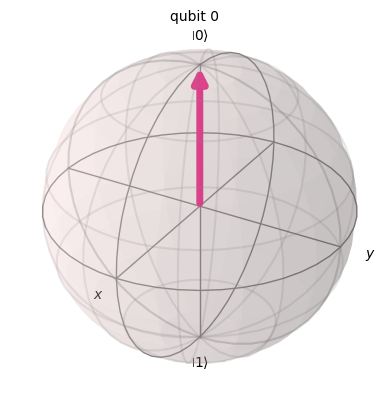


 X축을 기준으로 양의 방향으로 30도 회전


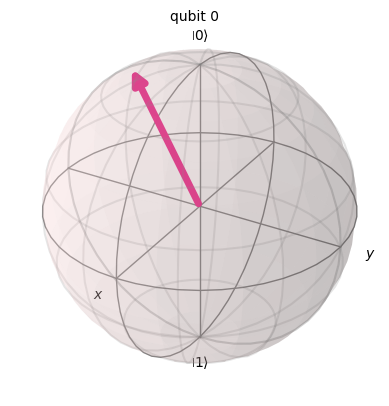


 X축을 기준으로 음의 방향으로 30도 회전


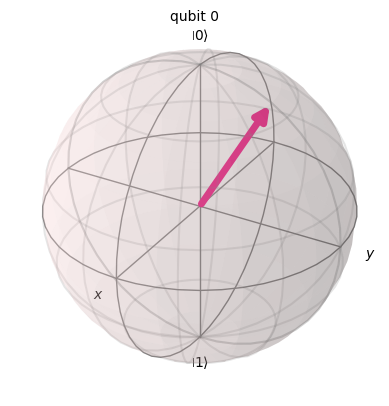


 X축을 기준으로 양의 방향으로 90도 회전


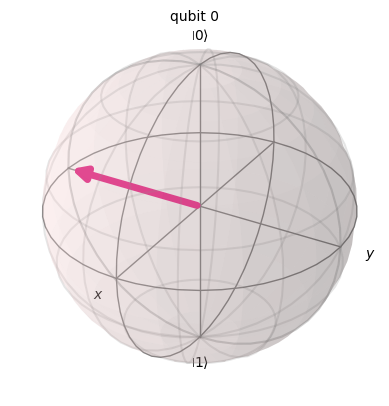

In [25]:
# Prepare single qubit quantum circuit
qc = QuantumCircuit(1)
print("초기 상태")
display(plot_bloch_multivector(qc))

print("\n X축을 기준으로 양의 방향으로 30도 회전")
qc = QuantumCircuit(1)
qc.rx(np.pi/6, 0)                               # 30 degrees = π/6 radians
display(plot_bloch_multivector(qc))

print("\n X축을 기준으로 음의 방향으로 30도 회전")
qc = QuantumCircuit(1)
qc.rx(-np.pi/6, 0)                              # -30 degrees = -π/6 radians
display(plot_bloch_multivector(qc))

print("\n X축을 기준으로 양의 방향으로 90도 회전")
qc = QuantumCircuit(1)
qc.rx(np.pi/2, 0)                               # 90 degrees = π/2 radians
display(plot_bloch_multivector(qc))

이제 다섯번째 문제를 시작하겠습니다!

In [26]:
controls = QuantumRegister(2, name="control")
target = QuantumRegister(1, name="target")

mid_measure = ClassicalRegister(2, name="mid")
final_measure = ClassicalRegister(1, name="final")

base = QuantumCircuit(controls, target, mid_measure, final_measure)

<div class="alert alert-block alert-success">

### Exercise 5: Make trial circuit

여러분이 가장 먼저 해야할 작업은 아래의 그림과 같은 양자 회로를 만들어주는 함수를 작성하는 것입니다. 

![CircuitRX](../img/circuitRx.png)

여러분이 아래의 회로를 더 쉽게 만드실 수 있도록 위의 코드 셀에서 `base` 양자 회로를 만들어 드렸습니다. `base` 양자 회로는 3개의 큐비트들과 3개의 고전비트를 가진 빈 회로 입니다.

**해야할 일**: 아래의 코드 셀에서 `trial` 함수를 완성시킵니다. `trial` 함수는 다음과 같은 순서로 양자 회로를 만드는 함수입니다.

1. 양자 회로에 있는 각각의 큐비트에 Hadamard 게이트를 가합니다.
2. Toffoli (controlled-controlled-not) 게이트를 control 큐비트들과 target 큐비트에 가합니다. Toffoli 게이트는 control 큐비트 2개가 모두 $|1\rangle$ 일 때, target 큐비트에 $X$ gate를 가하는 연산입니다. Toffoli 게이트를 사용하기 위해서는 QuantumCircuit의 `.ccx()` 매서드를 사용하시면 됩니다.
3. $S$ gate를 target 큐비트에 가합니다.
4. Step 2와 똑같은 control 큐비트와 target 큐비트을 대상으로 하는 toffoli 게이트를 가합니다.
5. Step 1과 같이 양자 회로에 있는 각각의 큐비트에 Hadamard 게이트를 가합니다.
6. 2개의 control 큐비트를 측정을 합니다.

</div>

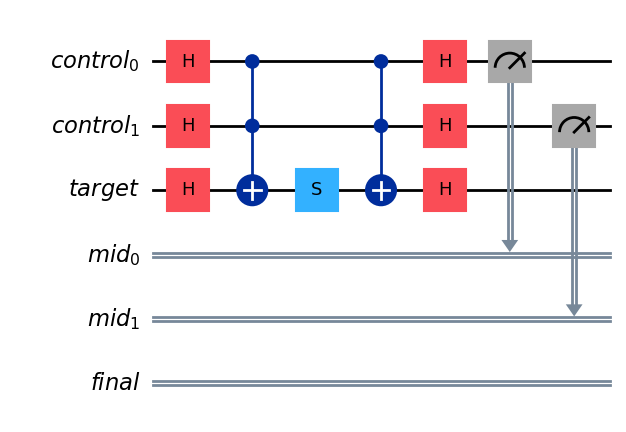

In [27]:
def trial(
    circuit: QuantumCircuit
):
    """Probabilistically perform Rx(theta) on the target, where cos(theta) = 3/5."""

    
    ### Write your code below this line, making sure it's indented to where this comment begins from ### 
    
    # Hint: You can start solving this problem by coding like this
    # circuit.h([0,1,2])
    circuit.h([0,1,2])
    circuit.ccx(0,1,2)
    circuit.s(2)
    circuit.ccx(0,1,2)
    circuit.h([0,1,2])
    circuit.measure([0,1],[0,1])

    ### Do not change the code below this line ###


qc = base.copy_empty_like()
trial(qc)

answer5 = qc.copy()
qc.draw("mpl", cregbundle=False)

In [28]:
### Grader Cell - Submit your answer by running the following code
### You do not need to add any code into this cell

from qff_2024ku_grader.challenges.qff_ku2024 import grade_challenge4e

grade_challenge4e(answer5, username)

Grading your answer. Please wait...

Congratulations 🎉! Your answer is correct.


<div class="alert alert-block alert-success">

### Exercise 6: Make reset_controls function

이제 여러분이 해야 할 다음 작업은 측정값을 확인 하는 것입니다. 만약 두 control qubits가 모두 $|0\rangle$로 관측이 되었다면, target qubit에 가해진 gate는 $\cos(\theta) = \frac{3}{5}$을 만족하는 $\theta$에 대해 $R_X(\theta)$ gate가 될 것입니다. 만약 둘 중 하나라도 $|1\rangle$ 이라면, target qubit에 가해지는 gate는 단순한 $X$ gate입니다(왜 이렇게 되는지는 직접 계산해보시면 좋을 것 같습니다!). 따라서, target qubit를 건드리지 않고 두 control qubits만 관측함으로써 target qubit에 알맞은 gate가 가해졌는지 확인할 수 있습니다.

만약 관측 결과를 보았을 때, target qubit에 원하는 gate가 가해지지 않았다고 결론 내릴 수 있는 경우, qubit을 리셋하고 다시 실행하면 됩니다. 실패했을 경우 어떠한 gate가 가해지는지 알 때에는 더 효율적으로 리셋을 할 수 있습니다. 먼저, $|1\rangle$로 관측된 control qubit은 $X$ gate를 가하여 $|0\rangle$로 만들 수 있습니다.

다음 셀에서 `reset_controls` 함수 내부를 채워주시길 바랍니다. `reset_controls`에서는 다음 과정들을 수행하도록 코딩하시면 됩니다.

1. 만약 첫번째 control qubit가 `measure`된 값이 1이라면, (리셋하기 위해)첫번째 control qubit에 $X$ gate를 가합니다.
2. 만약 두번째 control qubit가 `measure`된 값이 1이라면, (리셋하기 위해)두번째 control qubit에 $X$ gate를 가합니다.

</div>

<div class="alert alert-block alert-warning">

`if_test` 문을 총 두 번 이용하셔야 합니다.

</div>

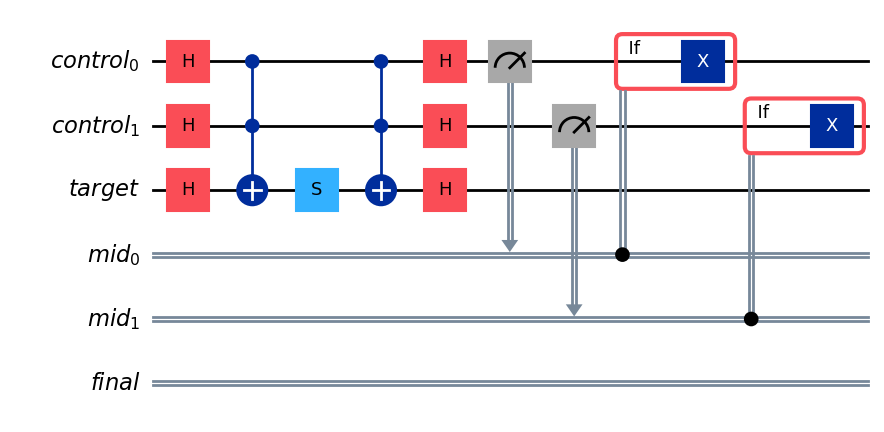

In [29]:
def reset_controls(
    circuit: QuantumCircuit, measures: ClassicalRegister
):
    """Reset the control qubits if they are in |1>."""

    
    ## Write your code below this line, making sure it's indented to where this comment begins from ## 

    with circuit.if_test((measures[0],1)):
        circuit.x(0)
    with circuit.if_test((measures[1],1)):
        circuit.x(1)

    ## Do not change the code below this line ##


qc = base.copy_empty_like()
trial(qc)
reset_controls(qc, mid_measure)

answer6 = qc.copy()
qc.draw("mpl", cregbundle=False)

In [30]:
### Grader Cell - Submit your answer by running the following code
### You do not need to add any code into this cell

from qff_2024ku_grader.challenges.qff_ku2024 import grade_challenge4f

grade_challenge4f(answer6, username)

Grading your answer. Please wait...

Congratulations 🎉! Your answer is correct.


작년까지만 해도 while_loop, for_loop, break_loop, continue_loop 와 같은 루프 문이 존재 하지 않아 조건에 따라서 계속해서 반복하는 것을 Qiskit으로 코딩하기 어려웠습니다.

하지만 이제는 이러한 루프들을 제공합니다. 이를 이용하여 성공할 때까지 반복 루프를 실행할 수 있습니다.

<div class="alert alert-block alert-success">

### Exercise 7: Repeating unitil success (final)

드디어 Repeat unitl success 회로를 완성시킬 차례입니다. 우리가 만들고자 하는 회로의 목표가 무엇인지 기억하시나요? $\{H,\,X,\,S,\,\text{Toffoli}\}$ 게이트들만을 이용하여 target 큐비트에 $\cos\theta = \frac35$인 $R_X(\theta)$ 게이트를 최종적으로 가하는 것입니다.

아래의 코드 셀에서, `while_loop` 문 내부의 코드를 작성해주시길 바랍니다. `while_loop` 에 들어가 있는 조건([final_measure, 0b0])은 항상 성립하는 조건 입니다. 즉, 무한루프이죠. 왜냐하면 `final_measure` 고전 비트는 이전에 측정 결과를 저장한 적이 없기에, 최종 측정 전까지는 항상 초기값 0 값을 가지고 있기 때문입니다.

**해야할 일**: 다음의 단계를 따라 코드를 작성해주세요.

1. while_loop 문 내부에 먼저 syndrome이 성공을 의미할 때 while_loop 문을 탈출하는 코드를 적어주세요. `if_test`와 `break_loop`메서드를 한번씩만 이용해 주세요. syndrome 값은 어디에 저장되어 있는지, 성공 상태가 무엇인지 생각해보시길 바랍니다.

2. 만약 syndrome 측정 결과를 보았을 때 target qubit에 우리가 원하는 연산을 못 가했다는 결론이 나면, 재시도를 하기 위해 target qubit을 $|0\rangle$로 초기화 시켜주어야 합니다. Exercise 6 설명에서 언급했다시피 syndrome 측정 상 원하는 연산을 가하는데 실패했을 경우 target qubit에는 $X$ 게이트가 가해졌기 때문에 target qubit는 $|1\rangle$ 상태입니다. 이것을 다시 $|0\rangle$ 상태로 만들기 위해서는 $X$ 게이트를 가해주어야 할 것입니다.(다른 게이트로도 $|1\rangle$를 $|0\rangle$으로 바꿔줄 수는 있지만 채점기의 정상 작동을 위해 $X$ 게이트를 가해주세요) **else** 문을 이용하지 마세요!!

3. `trial` 함수를 불러 다시 회로를 시도해 봅니다.

4. `reset_controls` 함수를 불러 control qubit 들을 다시 깔끔하게 초기화 시켜줍시다.

</div>

<div class="alert alert-block alert-info">

**주의:** 채점기의 정상 작동을 위해 위에서 말씀드린 것과 같이 `if_test` 메서드와 `break_loop` 메서드는 한 번만 이용해주시고, if_test에 이어지는 `else_`문은 이용하지 말아주세요.

</div>

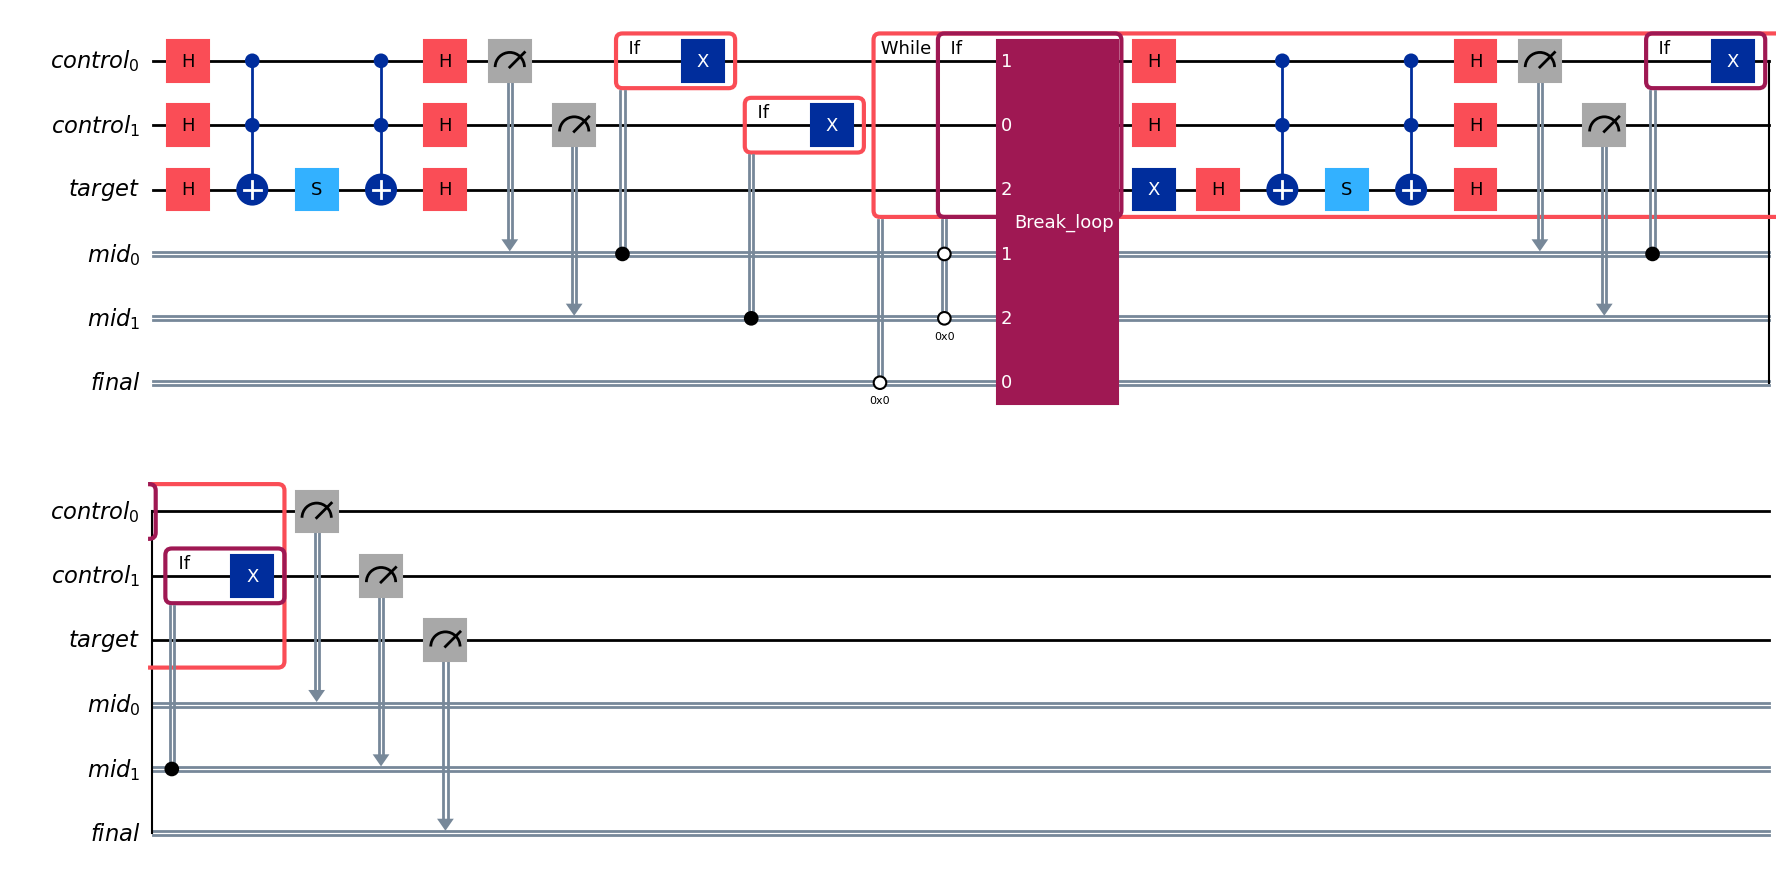

In [31]:
# Create a clean circuit with the same structure (bits, registers, etc) as the initial base we set up.
circuit = base.copy_empty_like()

# The first trial does not need to reset its inputs, since the controls are guaranteed to start in the |0> state.
trial(circuit)

reset_controls(circuit, mid_measure)
with circuit.while_loop(([final_measure, 0b0])): # Infinite loop
    ## Write your code below this line, making sure it's indented to where this comment begins from ## 
    with circuit.if_test((mid_measure, 0b00)):
        circuit.break_loop()
    circuit.x(target)
    trial(circuit)
    reset_controls(circuit, mid_measure)
    
    ## Do not change the code below this line ##

    
# We need to measure the control qubits again to ensure we get their final results; this is a hardware limitation.
circuit.measure(controls, mid_measure)

# Finally, let's measure our target, to check that we're getting the rotation we desired.
circuit.measure(target, final_measure)

answer7 = circuit.copy()
circuit.draw("mpl", cregbundle=False)

In [32]:
### Grader Cell - Submit your answer by running the following code
### You do not need to add any code into this cell

from qff_2024ku_grader.challenges.qff_ku2024 import grade_challenge4g

grade_challenge4g(answer7, username)

Grading your answer. Please wait...

Congratulations 🎉! Your answer is correct.


In [33]:
# initialize the backend and sampler
backend = AerSimulator()
sampler = Sampler(backend)

# Make a pub and execute our circuit
pub = (circuit)
job_sampler = sampler.run([pub], shots=10000)

result_sampler = job_sampler.result()
counts_sampler = result_sampler[0].data.final.get_counts()

print(f"Counts: {counts_sampler}")

Counts: {'0': 7994, '1': 2006}


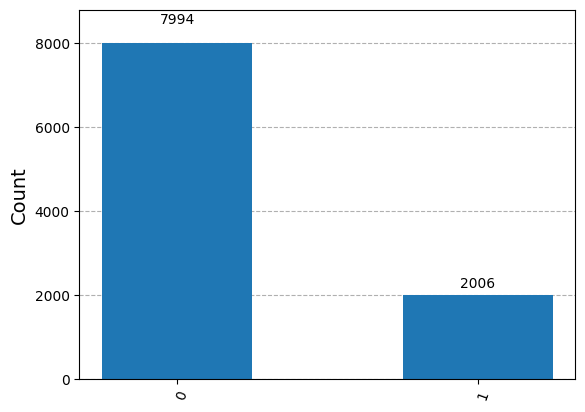

In [34]:
plot_histogram(counts_sampler)

Target qubit에 $\cos\theta = \frac35$인 $R_X(\theta)$ 게이트를 성공적으로 가하는데 성공하셨나요? 축하드립니다!

<div class="alert alert-block alert-success">

### Exercise 8: Result Analysis

위에서 여러분은 Target qubit에 $\cos\theta = \frac35$인 $R_X(\theta)$ 게이트를 가하셨습니다. 이러한 연산이 가해졌을 때, Target qubit를 측정하였을 때 $|0\rangle$이 관측될 확률과 $|1\rangle$이 관측될 확률을 구하세요.

**해야할 일**: 아래의 코드 셀을 보시면 딕셔너리 자료형의 `answer8`을 선언해 두었습니다. 각각의 키에 해당하는 밸류값으로 해당 키 값이 관측될 확률을 넣어주시면 됩니다.

</div>

<div class="alert alert-block alert-info">

$R_X(\theta)$ 는 다음과 같은 연산이라고 말씀드렸었습니다.

$$R_X(\theta) = exp(-i\frac{\theta}{2}X) = \begin{bmatrix}\cos(\frac{\theta}{2})&-i\sin(\frac{\theta}{2})\\-i\sin(\frac{\theta}{2})&\cos(\frac{\theta}{2})\\ \end{bmatrix}$$

</div>

In [35]:
answer8 = {}

answer8['0'] = 4/5 ## add your code here
answer8['1'] = 1/5 ## add your code here

In [36]:
### Grader Cell - Submit your answer by running the following code
### You do not need to add any code into this cell

from qff_2024ku_grader.challenges.qff_ku2024 import grade_challenge4h

grade_challenge4h(answer8, username)

Grading your answer. Please wait...

Congratulations 🎉! Your answer is correct.


## Congratulations!

축하드립니다! 이제 여러분은 Qiskit으로 classical feedforward and control flow 하는 법을 마스터하셨습니다! 다른 챌린지 문제들도 파이팅입니다!